In [2]:
!pip install lime

In [0]:
# import dependencies
import pandas as pd
import torch
import cv2

import torch
from torch.utils.data import Dataset
from PIL import Image
import os
from torchvision import transforms


from torch.nn import functional as F
from torch import nn, optim

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [5]:
cd './drive/My Drive/MLHC Project Resources/python_code/'

/content/drive/My Drive/MLHC Project Resources/python_code


In [15]:
from load_model import load_model

classifier_model = load_model()


=> loading checkpoint
=> loaded checkpoint


In [6]:
# specify global vars
DATA_DIR = './files/chex-ray-14'
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device = {device}")


Device = cuda


In [7]:
# check what files we actually have on our google drive
files = os.listdir(DATA_DIR)
img_ids = [file for file in files if '.png' in file]
print(f"Number of Images on Google Drive: {len(img_ids)}")

Number of Images on Google Drive: 10015


In [0]:
class ChestXrayDataSet(Dataset):
    def __init__(self, data_dir, list_of_image_list_file, subset_img_ids, transform=None):
        """
        Args:
            data_dir: path to image directory.
            list_of_image_list_file:  list of paths to the file containing images
                with corresponding labels.
            subset_img_ids: a subset of images that we actually have
            transform: optional transform to be applied on a sample.
        """
        image_names = []
        labels = []
        for image_list_file in list_of_image_list_file:
          with open(image_list_file, "r") as f:
              for line in f:
                  items = line.split()
                  image_name= items[0]
                  if image_name in subset_img_ids:
                      label = items[1:]
                      label = [int(i) for i in label]
                      image_name = os.path.join(data_dir, image_name)
                      image_names.append(image_name)
                      labels.append(label)

        self.image_names = image_names
        self.labels = labels
        if transform is not None:
            self.transform = transform

    def __getitem__(self, index):
        """
        Args:
            index: the index of item
        Returns:
            image and its labels
        """
        image_name = self.image_names[index]
        image = Image.open(image_name).convert('RGB')
        label = self.labels[index]
        if self.transform is not None:
            image = self.transform(image)
        return image, torch.FloatTensor(label)

    def __len__(self):
        return len(self.image_names)

    def __get_original_image__(self, index):
        """
        Note: This is a custom function that helps to pull the original image
        """
        image_name = self.image_names[index]
        image = Image.open(image_name).convert('RGB')
        label = self.labels[index]
        local_transforms = transforms.Resize(256)
        return np.array(local_transforms(image)), torch.FloatTensor(label)

In [0]:
classifier_normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                 [0.229, 0.224, 0.225])
classifier_transformer = transforms.Compose([transforms.Resize(256),
                                  transforms.TenCrop(224),
                                  transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
                                  transforms.Lambda(lambda crops: torch.stack([classifier_normalize(crop) for crop in crops]))
                                ])

classifier_dataset = ChestXrayDataSet(data_dir = DATA_DIR,
                            list_of_image_list_file = [DATA_DIR + '/train_list.txt',
                                               DATA_DIR + '/val_list.txt',
                                               DATA_DIR + '/test_list.txt'],
                            subset_img_ids = img_ids, 
                            transform = classifier_transformer)

## Modified LIME

In [0]:
import copy
from functools import partial
import numpy as np
import sklearn
import sklearn.preprocessing
from sklearn.utils import check_random_state
from skimage.color import gray2rgb
from tqdm.auto import tqdm
from lime import lime_base 
from sklearn.metrics import pairwise_distances
from lime.lime_image import ImageExplanation
from lime.wrappers.scikit_image import SegmentationAlgorithm


class LimeImageExplainerModified(object):
    """Explains predictions on Image (i.e. matrix) data.
    For numerical features, perturb them by sampling from a Normal(0,1) and
    doing the inverse operation of mean-centering and scaling, according to the
    means and stds in the training data. For categorical features, perturb by
    sampling according to the training distribution, and making a binary
    feature that is 1 when the value is the same as the instance being
    explained."""

    def __init__(self, kernel_width=.25, kernel=None, verbose=False,
                 feature_selection='auto', random_state=None):
        """Init function.
        Args:
            kernel_width: kernel width for the exponential kernel.
            If None, defaults to sqrt(number of columns) * 0.75.
            kernel: similarity kernel that takes euclidean distances and kernel
                width as input and outputs weights in (0,1). If None, defaults to
                an exponential kernel.
            verbose: if true, print local prediction values from linear model
            feature_selection: feature selection method. can be
                'forward_selection', 'lasso_path', 'none' or 'auto'.
                See function 'explain_instance_with_data' in lime_base.py for
                details on what each of the options does.
            random_state: an integer or numpy.RandomState that will be used to
                generate random numbers. If None, the random state will be
                initialized using the internal numpy seed.
        """
        kernel_width = float(kernel_width)

        if kernel is None:
            def kernel(d, kernel_width):
                return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))

        kernel_fn = partial(kernel, kernel_width=kernel_width)

        self.random_state = check_random_state(random_state)
        self.feature_selection = feature_selection
        self.base = lime_base.LimeBase(kernel_fn, verbose, random_state=self.random_state)
    
    def explain_instance_with_neighbours(self, 
                                        original_image_id,
                                        neighbour_ids,
                                        classifier_model,
                                        n_permute = 100,
                                        top_labels= 14, 
                                        num_features=100000,
                                        num_samples=1000,
                                        segmentation_fn=None,
                                        distance_metric='cosine',
                                        model_regressor=None,
                                        random_seed=None):
        
        original_img, original_lab = classifier_dataset.__get_original_image__(original_image_id)

        # kernel size inversely related to segment size
        segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=2,
                                                    max_dist=200, ratio=0.2,
                                                    random_seed=42)
        
        segments = segmentation_fn(original_img)

        data, labels = self.get_predictions_for_neighbours(original_image_id,
                                                           original_img,
                                                           segments,
                                                           neighbour_ids,
                                                           n_permute,
                                                           classifier_model)
        
        # print(data,labels)
        distances = sklearn.metrics.pairwise_distances(
            data,
            data[0].reshape(1, -1),
            metric=distance_metric
        ).ravel()

        ret_exp = ImageExplanation(original_img, segments)
        
        if top_labels:
            top = np.argsort(labels[0])[-top_labels:]
            ret_exp.top_labels = list(top)
            ret_exp.top_labels.reverse()
        for label in top:
            (ret_exp.intercept[label],
             ret_exp.local_exp[label],
             ret_exp.score, ret_exp.local_pred) = self.base.explain_instance_with_data(
                data, labels, distances, label, num_features,
                model_regressor=model_regressor,
                feature_selection=self.feature_selection)
        return ret_exp
            
    def get_predictions_for_neighbours(self,
                                       original_img_id,
                                       original_img,
                                       segments,
                                       neighbour_ids,
                                       n_permute,
                                       classifier_model):
        """
        Args:
            segments: from quickshift algorithm
            neighbour ids: np.array of neighbour_ids
            n_permute: number of permutations per neighbour
        
        Global Variable Dependencies:
            classifier_dataset
            classifier_transformer
            classifier_model
        
        Returns:
            data: (n_examples, n_features), entry(i,j)= 1 where superpixel j is present in entry i
            labels: (n_examples, n_classes) 
            n_examples = 1 + n_neighbours* n_permute
        """
        #print(f"Neighbour Ids {neighbour_ids}")
        n_features = np.unique(segments).shape[0]
        n_neighbours = neighbour_ids.shape[0]

        data = np.zeros(( 1 + (n_neighbours + 1)* n_permute,n_features))
        # all superpixels are present for original image
        images_tensor = torch.zeros(( 1+ (n_neighbours + 1)* n_permute, 10, 3, 224, 224))
        labels = []
        # store for original image, all superpixels present
        data[0,:] = 1
        original_img_transformed = classifier_transformer(Image.fromarray(original_img.astype(np.uint8)))
        original_pred = classifier_model(original_img_transformed).mean(0).detach().cpu().numpy()
        labels.append(original_pred)
        to_permute = np.append(neighbour_ids, original_img_id)
        print(to_permute)
        for nb_count, nb_id in enumerate(to_permute):
            for x in range(n_permute):
                # feature_combinations is a binary vector with 1 if the superpixel is included and 0 otherwise 
                feature_combinations = np.random.randint(0,2,n_features)
                # keep track of what super pixels are included and excluded
                data[nb_count * n_permute + x, :] = feature_combinations

                zero_out = np.where(feature_combinations == 0)
                mask = np.isin(segments, zero_out).astype(int)

                nb, _ = classifier_dataset.__get_original_image__(nb_id)
                nb_masked = np.multiply(np.repeat(mask[:,:,np.newaxis],3,axis=2),nb)
                transformed_nb_masked = classifier_transformer(Image.fromarray(nb_masked.astype(np.uint8)))
                pred = classifier_model(transformed_nb_masked)
                pred_mean = pred.mean(0).detach().cpu().numpy()
                labels.append(pred_mean)

        return data, np.array(labels)
        

## VAE Code 
- Load pretrained model, gets nearest neighbours

In [0]:

class VAE(nn.Module):
    
    def __init__(self):
        super(VAE, self).__init__()
        DIM = 224
        LATENT_DIM = 60
        self.fc1 = nn.Linear(DIM * DIM, 500)
        self.fc21 = nn.Linear(500, LATENT_DIM)
        self.fc22 = nn.Linear(500, LATENT_DIM)
        self.fc3 = nn.Linear(LATENT_DIM, 500)
        self.fc4 = nn.Linear(500, DIM * DIM)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, DIM*DIM))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, DIM*DIM), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

def load_vae_model(model_save_name):
  path = F"./vae_models/{model_save_name}.pt" 
  model = VAE()
  model.load_state_dict(torch.load(path))
  print(f"Model successfully loaded from {path}")
  model.to(device)
  return model

In [0]:
vae_model = load_vae_model('10k_vae60_dim224_epoch25_batch64_A-12_09-May-2020 (18:54:22.919440)')

DIM = 224
LATENT_DIM = 60

vae_transformer = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                      transforms.Resize((DIM,DIM)),
                                      transforms.ToTensor()])

vae_dataset = ChestXrayDataSet(data_dir = DATA_DIR,
                             list_of_image_list_file = [DATA_DIR + '/train_list.txt',
                                                DATA_DIR + '/val_list.txt',
                                                DATA_DIR + '/test_list.txt'],
                             subset_img_ids = img_ids, 
                             transform = vae_transformer)


Model successfully loaded from ./vae_models/10k_vae60_dim224_epoch25_batch64_A-12_09-May-2020 (18:54:22.919440).pt


In [0]:
from sklearn.metrics import pairwise_distances

def get_latent_representations_and_labels(test_dataset, idx, model):
  images, labels = test_dataset[idx]
  mu,logvar = model.encode(images.to(device).view(-1, DIM*DIM))
  latent_representations = model.reparameterize(mu, logvar)
  return latent_representations.squeeze(), labels

def compute_labels(index, labels_tensor):
  CLASS_NAMES = [ 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia','Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
  N_LABELS = len(CLASS_NAMES)
  if sum(labels_tensor[index,:]) == 0:
    return "None"
  else:
    return''.join([CLASS_NAMES[i] for i in range(N_LABELS) if labels_tensor[index,i] == 1])

def compute_nearest_neighbours(latent_representation_tensor, num_nearest_neighbours = 10):
  distance_matrix = pairwise_distances(latent_representation_tensor.detach().numpy())
  np.fill_diagonal(distance_matrix, np.inf)
  nearest_neighbours = np.argsort(distance_matrix, axis = 1)[:,:num_nearest_neighbours]
  num_examples = nearest_neighbours.shape[0]
  conditions_matrix = np.chararray((num_examples,1+num_nearest_neighbours), itemsize = 20)
  for i in range(num_examples):
    conditions_matrix[i,0] = compute_labels(i, labels_tensor)
    neighbours_of_i = nearest_neighbours[i,:]
    for (j,n) in enumerate(neighbours_of_i):
      conditions_matrix[i,j+1] = compute_labels(n,labels_tensor) 
  
  column_1 = [f'neighbour_{i+1}' for i in range(num_nearest_neighbours)]
  column_2 = ['condition'] + [f'neighbour_{i+1}_condition' for i in range(num_nearest_neighbours)]

  result = pd.concat( [pd.DataFrame(nearest_neighbours, columns = column_1),
                       pd.DataFrame(conditions_matrix.decode('utf-8'), columns = column_2)
                       ], axis = 1)
  
  return(result)


In [0]:
# Computation of nearest neighbours
# N_EXAMPLES = 10000
# N_LABELS = 14
# latent_representation_tensor = torch.zeros((N_EXAMPLES,LATENT_DIM))
# labels_tensor = torch.zeros((N_EXAMPLES,N_LABELS))
# for i in range(N_EXAMPLES):
#   latent_representation_tensor[i,:], labels_tensor[i,:] = get_latent_representations_and_labels(vae_dataset,i,vae_model)

#   if i > 0:
#       if (i%1000 == 0):
#         nearest_neighbours_df  = compute_nearest_neighbours(latent_representation_tensor,num_nearest_neighbours=10)
#         nearest_neighbours_df.to_csv(f"vae_nearest_neighbours_first_{i}_ids.csv")

# nearest_neighbours_df.to_csv(f"vae_nearest_neighbours_first_{10000}_ids.csv",  index=False)

## Applying Lime to Nearest Neighbours

In [0]:
vae_nearest_neighbours = pd.read_csv("./vae_nearest_neighbours_first_10000_ids.csv")
cases_with_pneumothorax_only = vae_nearest_neighbours[vae_nearest_neighbours['condition'] == 'Pneumothorax'].reset_index().rename(columns={'index':'original_image'})

In [12]:
cases_with_pneumothorax_only

,original_image,neighbour_1,neighbour_2,neighbour_3,neighbour_4,neighbour_5,neighbour_6,neighbour_7,neighbour_8,neighbour_9,neighbour_10,condition,neighbour_1_condition,neighbour_2_condition,neighbour_3_condition,neighbour_4_condition,neighbour_5_condition,neighbour_6_condition,neighbour_7_condition,neighbour_8_condition,neighbour_9_condition,neighbour_10_condition
0,0,749,4605,3268,3210,1,5685,1835,503,7065,6500,Pneumothorax,None,None,None,None,None,None,None,None,Mass,Pneumonia
1,42,8688,2541,6861,44,8734,6148,2965,2267,39,2211,Pneumothorax,None,Emphysema,None,AtelectasisPneumotho,Atelectasis,None,Infiltration,None,AtelectasisConsolida,None
2,47,1886,65,8923,6885,7631,48,4646,7638,8922,142,Pneumothorax,InfiltrationMass,None,EffusionEdema,Infiltration,EffusionInfiltration,EffusionInfiltration,Effusion,Effusion,Edema,None
3,99,1633,7645,952,5006,2922,707,4398,939,7619,1114,Pneumothorax,Infiltration,CardiomegalyEffusion,AtelectasisInfiltrat,Atelectasis,None,InfiltrationPneumoni,None,None,CardiomegalyInfiltra,EffusionConsolidatio
4,102,7618,1203,671,2457,100,6263,1528,7898,3793,5191,Pneumothorax,None,None,None,InfiltrationNodule,EffusionPneumothorax,None,Infiltration,None,None,InfiltrationConsolid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,8547,4764,7204,1425,642,2666,1474,5738,7507,8541,3916,Pneumothorax,None,None,AtelectasisConsolida,None,Consolidation,None,Nodule,None,Edema,None
116,8548,8889,8811,4891,290,6415,3682,6867,2825,6,8335,Pneumothorax,AtelectasisInfiltrat,Mass,Edema,None,Nodule,None,None,None,Atelectasis,Pneumothorax
117,8719,3839,1830,1567,6978,5862,3102,4593,4112,4010,719,Pneumothorax,None,EffusionNodule,AtelectasisEffusionC,None,None,None,None,None,None,Mass
118,8996,9000,653,3447,3450,5725,1426,3417,3322,1298,1306,Pneumothorax,Pneumothorax,AtelectasisInfiltrat,None,None,Consolidation,Atelectasis,None,Infiltration,InfiltrationConsolid,None


In [0]:
cases_with_pneumothorax_only[cases_with_pneumothorax_only['original_image']==3316]

,original_image,neighbour_1,neighbour_2,neighbour_3,neighbour_4,neighbour_5,neighbour_6,neighbour_7,neighbour_8,neighbour_9,neighbour_10,condition,neighbour_1_condition,neighbour_2_condition,neighbour_3_condition,neighbour_4_condition,neighbour_5_condition,neighbour_6_condition,neighbour_7_condition,neighbour_8_condition,neighbour_9_condition,neighbour_10_condition
45,3316,7538,1810,3322,8844,4934,1432,4722,1438,1447,2190,Pneumothorax,EffusionInfiltration,Consolidation,Infiltration,MassPneumothorax,Consolidation,Infiltration,Mass,None,MassConsolidation,Infiltration


In [0]:
from skimage.segmentation import mark_boundaries

def pred_to_labels(labels_tensor):
  CLASS_NAMES = [ 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia','Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
  N_LABELS = len(CLASS_NAMES)
  if sum(labels_tensor) == 0:
    return "None"
  else:
    return''.join([CLASS_NAMES[i] for i in range(N_LABELS) if labels_tensor[i] == 1])

def plot_explanation_rich(explanation, condition, original_image_id = None, neighbour_ids = None, positive_only = True):
    CLASS_NAMES = [ 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
                    'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']
    
    class_names_to_class_id = {c:i for (i,c) in enumerate(CLASS_NAMES)}
    if condition not in CLASS_NAMES:
      print("Condition not Recognised")
      return
    

    class_id = class_names_to_class_id[condition]

    class_id_to_explainer_id = {class_idx:idx for (idx,class_idx) in enumerate(explanation.top_labels)}
    explainer_id = class_id_to_explainer_id[class_id]
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[explainer_id], 
                                                    positive_only=positive_only, 
                                                    num_features=10, 
                                                    hide_rest=False)
    nb_imgs = []
    original_img, original_label = classifier_dataset.__get_original_image__(original_image_id)
    
    if neighbour_ids is not None:
      num_plot = 1+ 1+ len(neighbour_ids)
      fig, axs = plt.subplots(1, num_plot , figsize = (num_plot*8,8), sharey=True)
    else:
      fig, axs = plt.subplots(1, 2, figsize = (16,8), sharey=True)

    axs[0].imshow(original_img)
    axs[0].set_title(f"Original Image \n Ground Truth = {pred_to_labels(original_label)}", fontsize = 20)
    img_boundry2 = mark_boundaries(temp, mask)
    axs[1].imshow(img_boundry2)
    axs[1].set_title("KP-LIME Explanation",fontsize = 20)
    
    if neighbour_ids is not None:
      for (x, nb_id) in enumerate(neighbour_ids):
        nb, nb_label = classifier_dataset.__get_original_image__(nb_id)
        axs[2+x].imshow(nb)
        axs[2+x].set_title(f"Neighbour {x+1} \n Ground Truth = {pred_to_labels(nb_label)}", fontsize = 20)
    fig.suptitle(f'Condition being Explained: {condition}', fontsize = 30)
    return fig

[8688 2541 6861   44 8734   42]


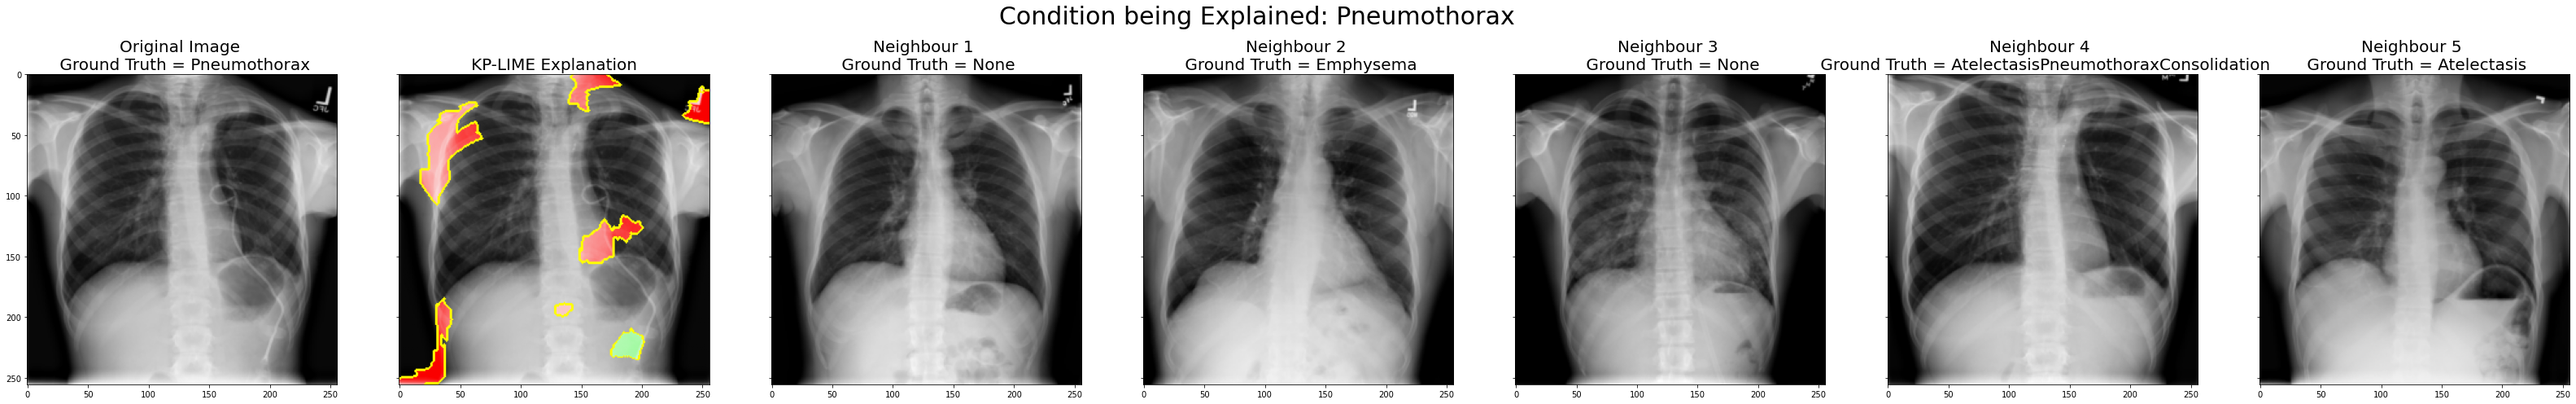

In [0]:
explainer_mod = LimeImageExplainerModified()
neighbour_ids = np.array([8688,	2541,	6861,	44,	8734])
explanation = explainer_mod.explain_instance_with_neighbours(42,neighbour_ids,classifier_model,
                                                             n_permute=5) 
# n_permute = 5 for fast running. this is an illustrative example
output = plot_explanation_rich(explanation, 'Pneumothorax', 42, neighbour_ids, positive_only = False)

In [0]:
# Loop through Pneumothorax Explainer:

for i in range(cases_with_pneumothorax_only.shape[0]):
    original_id = cases_with_pneumothorax_only.loc[i,'original_image']
    neighbour_of_original = []
    for n in range(5):
      neighbour_id = cases_with_pneumothorax_only.loc[i,f'neighbour_{n+1}']
      neighbour_of_original.append(neighbour_id)
      
    # now explaining i

    explainer_mod = LimeImageExplainerModified()
    neighbour_of_original = np.array(neighbour_of_original)
    explanation = explainer_mod.explain_instance_with_neighbours(original_id,neighbour_of_original,classifier_model,n_permute=200)
    cur_plot = plot_explanation_rich(explanation, 'Pneumothorax', original_id, neighbour_of_original)
    cur_plot.savefig(f"./lime_output_plotter/explanation_pneumothorax_image_{original_id}.png")
    print(f"Saved original id {original_id}")
    plt.close(cur_plot)

[ 749 4605 3268 3210    1    0]
Saved original id 0
[8688 2541 6861   44 8734   42]
Saved original id 42
[1886   65 8923 6885 7631   47]
Saved original id 47
[1633 7645  952 5006 2922   99]
Saved original id 99
[7618 1203  671 2457  100  102]
Saved original id 102
[5364 6311 6795 5369 6320  119]
Saved original id 119
[5797 1242  144 4374 6591  231]
Saved original id 231
[8752 4502  568 8488 7965  373]
Saved original id 373
[1142 1801 7603 6993 1141  571]
Saved original id 571
[ 657 4391 4392 3504 4381  656]
Saved original id 656
[ 656 3670 3513 5457 4392  657]
Saved original id 657
[ 243 7743 2103 2419 1063 1080]
Saved original id 1080
[6771  482 5843 4434 1124 1081]
Saved original id 1081
[7552 5547 1142 1129 5386 1141]
Saved original id 1141
[7552 1136 1141 7740 5385 1143]
Saved original id 1143
[4977 4980 8221 8499 2938 1177]
Saved original id 1177
[1361 6609  816 1838 1364 1362]
Saved original id 1362
[3712 2624 3492 6750 3261 1739]
Saved original id 1739
[7286 5174 1743  588 5993 

KeyboardInterrupt: ignored

In [0]:
# Loop through Pneumothorax Explainer:

for i in range(cases_with_pneumothorax_only.shape[0]):
    if i > 0:
      original_id = cases_with_pneumothorax_only.loc[i,'original_image']
      neighbour_of_original = []
      for n in range(5):
        neighbour_id = cases_with_pneumothorax_only.loc[i,f'neighbour_{n+1}']
        neighbour_of_original.append(neighbour_id)
        
      # now explaining i

      explainer_mod = LimeImageExplainerModified()
      neighbour_of_original = np.array(neighbour_of_original)
      explanation = explainer_mod.explain_instance_with_neighbours(original_id,neighbour_of_original,classifier_model,n_permute=200)
      cur_plot = plot_explanation_rich(explanation, 'Pneumothorax', original_id, neighbour_of_original, positive_only = False)
      cur_plot.savefig(f"./lime_output_plotter/green_red_explanation_pneumothorax_image_{original_id}.png")
      print(f"Saved original id {original_id}")
      plt.close(cur_plot)

[8688 2541 6861   44 8734   42]
Saved original id 42
[1886   65 8923 6885 7631   47]
Saved original id 47
[1633 7645  952 5006 2922   99]
Saved original id 99
[7618 1203  671 2457  100  102]
Saved original id 102
[5364 6311 6795 5369 6320  119]
Saved original id 119
[5797 1242  144 4374 6591  231]
Saved original id 231
[8752 4502  568 8488 7965  373]
Saved original id 373
[1142 1801 7603 6993 1141  571]
Saved original id 571
[ 657 4391 4392 3504 4381  656]
Saved original id 656
[ 656 3670 3513 5457 4392  657]
Saved original id 657
[ 243 7743 2103 2419 1063 1080]
Saved original id 1080
[6771  482 5843 4434 1124 1081]
Saved original id 1081
[7552 5547 1142 1129 5386 1141]
Saved original id 1141
[7552 1136 1141 7740 5385 1143]
Saved original id 1143
[4977 4980 8221 8499 2938 1177]
Saved original id 1177
[1361 6609  816 1838 1364 1362]
Saved original id 1362
[3712 2624 3492 6750 3261 1739]
Saved original id 1739
[7286 5174 1743  588 5993 1740]
Saved original id 1740
[1736 8504 1165 8740 20